In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
import pickle
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import rasterio
import shapely
from scipy.optimize import minimize
from shapely.geometry import *
import time
import shutil

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "test_3D"
exe_name= "../../exe/mf6"

In [3]:
#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

In [4]:
# load dis infos
top,botm,idomain,delr,delc = read_pickle(os.path.join(model_dir,"export_dis3D"))

In [5]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
x0,y0,x1,y1 = rasterio.open(MNT_path).bounds

nlay = idomain.shape[0]
ncol = idomain.shape[2]
nrow = idomain.shape[1]

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

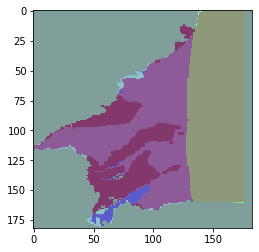

In [6]:
# a little plot
#idomain[idomain==0]=None
plt.imshow(idomain[1],alpha=0.4,cmap="bone")
plt.imshow(idomain[2],alpha=0.4,cmap="hot")
plt.imshow(idomain[0],alpha=0.4,cmap="winter")
plt.imshow(idomain[3],alpha=0.4,cmap="jet")

In [7]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))

In [8]:
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [9]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];chd_va=0.1
for x in lst_chd:
    chd_v = -0.025*top[x[1],x[2]] #equivalent freshwater head
    if chd_v < 0:
        chd_v = chd_va
    chd_lst.append((x,chd_v))
    chd_va=chd_v
    #chd_lst.append((x,0.1))

In [10]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))

In [11]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.005,0.005,0.005,0.005,0.005,0.005]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],1.5)

In [12]:
# Prelevements
geol_col = "NAPPE_CAPT" #name of lithology column
v_col = "VOL_2013" # name of the volume column
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp" # path to shp
BD = gp.read_file(path)
coeff = 1

#remove points with no geometry info
for i in range(BD.shape[0]):
    if BD.geometry[i]==None:
        BD.drop(i,axis=0,inplace=True)
BD  = BD[BD["USAGES"]!="IRRIGATION"]

stress_data_well = importWells3D(BD,grid,lst_domain,fac=coeff*1/365/86400,V_col=v_col, geol_col=geol_col,
                                 geol_layer=["PLIOCENE","QUATERNAIRE","INDETERMINE"],layer_num=[[3,4],1,[1,3,4]])

In [13]:
# Prelevements agricoles
path_Q = "../../data/prélèvements/prlvm_agri_Q.asc"
path_P = "../../data/prélèvements/prlvm_agri_P.asc"
p_agri_Q = rspl_rast(path_Q,grid)
p_agri_P = rspl_rast(path_P,grid)

#pertes
p_agri_Q*=1.25*coeff # 20% de pertes
p_agri_Q*=1.25*coeff

# make a list for rch package
## PQ
p_agr=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if p_agri_Q[irow,icol] != 0:
        if (1,irow,icol) in lst_domain:
            p_agr.append(((1,irow,icol),p_agri_Q[irow,icol]/1000/365/86400))
    if p_agri_P[irow,icol] != 0:
        if (3,irow,icol) in lst_domain:
            p_agr.append(((3,irow,icol),p_agri_P[irow,icol]/1000/365/86400))
        else:
            if (4,irow,icol) in lst_domain:
                p_agr.append(((4,irow,icol),p_agri_P[irow,icol]/1000/365/86400))


In [14]:
np.sum(p_agri_Q)*300*300/1000

-16424385.46875

In [15]:
np.sum(p_agri_P)*300*300/1000

-6977581.875

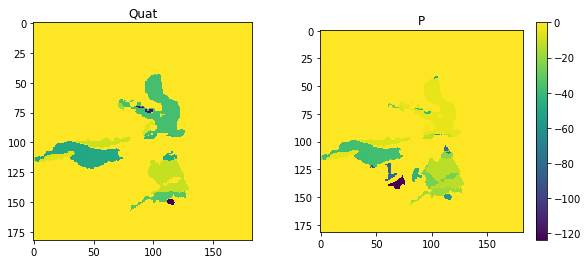

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(p_agri_Q)
ax[0].set(title="Quat")
g=ax[1].imshow(p_agri_P)
ax[1].set(title="P")
plt.colorbar(g)

In [17]:
# recharge
rch_path="../../data/recharge/recharge_p.tif"
rch = rspl_rast(rch_path,grid) # resample to grid
rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
rch[idomain[0]==1]=0 # remove some rch
for cell in etangs_chd:
    rch[cell[1],cell[2]]=0
    
rch = liss_mob(rch,5)
coeff_rch = 1

# make a list for rch package
rch_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if rch[irow,icol] > 0:
        rch_lst.append(((icell),coeff_rch*rch[irow,icol]/1000/365/86400))

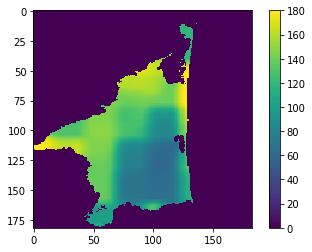

In [18]:
plt.imshow(rch,vmax=180)
plt.colorbar()

In [19]:
#recharge irrigation
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0
coeff_irr=1
irr*=coeff_irr

irr_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if irr[irow,icol] !=0:
        irr_lst.append(((icell),irr[irow,icol]/1000/365/86400))

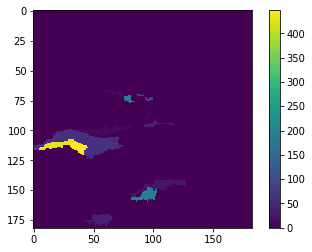

In [20]:
plt.imshow(irr)
plt.colorbar()

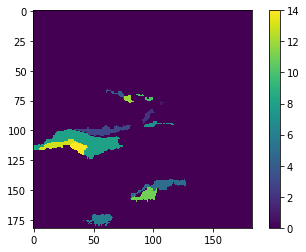

In [21]:
list_val = np.unique(irr)[1:]
for i,ival in enumerate(list_val):
    irr[irr==ival]=i+1
plt.imshow(irr)
plt.colorbar()

In [30]:
# permeability
k = np.ones([nlay,nrow,ncol])*1e-4
k[0] = 1e-5
k[1] = 2e-3 # Q
k[2] = 0.25e-8 # interQ/PC
k[3] = 9.95e-5 #PC
k[4] = 1.19e-5 # PMS

add_zone = 1 # add_zone = 1 to add the 2 conductivity zones
if add_zone == 1:
    
    ###### zone sud peu perméable
    z1 = [(689e3,616e4),(695e3,616.3e4),(700e3,616.3e4),(700e3,615.2e4),(689e3,615.2e4)]
    layer = [1,3,4]
    kn = 2.71e-5
    k_zones (k,z1,layer,kn,ix) # change k with new kn value in the z1 zone at layer indicates, ix is the gridintersect object

    #### permeabilité de la zone Villeneuve
    x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
    zv = [(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)]
    layer = [1,3,4]
    kn = 1.19e-5
    k_zones(k,zv,layer,kn,ix)

    ### permea alluv ancien Tet
    shp = "../../data/shp/entités/Tet_Q_anc.shp"
    poly = gp.read_file(shp).geometry[0]
    layer = [1]
    kn = 7.55e-4
    k_zones(k,poly,layer,kn,ix)

np.savetxt(os.path.join(model_dir,"kqm.txt"),k[0])
np.savetxt(os.path.join(model_dir,"kq.txt"),k[1])
np.savetxt(os.path.join(model_dir,"kep.txt"),k[2])
np.savetxt(os.path.join(model_dir,"kpc.txt"),k[3])
np.savetxt(os.path.join(model_dir,"kpms.txt"),k[4])

In [23]:
## Thuir
layer = [1,3]
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])
plio_chd = []

for layer in layer:
    BDcells = cellidBD(idomain,layer=layer)

    for cellid in ix.intersect_polygon(poly).cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            if layer == 1:
                plio_chd.append((cell,140))
            if layer == 3:
                plio_chd.append((cell,115))

In [24]:
# Corbières
layer = [3,4]
Corb_lst = []
Corb_spd = []
flux = 0.2
    
for layer in layer:
    BDcells = cellidBD(idomain,layer)
    poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

    res = ix.intersect_polygon(poly)
    for cellid in res.cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            Corb_lst.append(cell)
    n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [25]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

# Return a 3d array (nlay,nrow,ncol) that can be directly substract with head (each pz is a measure of one cell)

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [32]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

# recharge
rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

# irrigation
irri = fp.mf6.ModflowGwfrch(gwf,pname="irrig",filename="irri.rch",maxbound=len(irr_lst),stress_period_data=irr_lst,save_flows=True)

p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_agri",filename="p_agri.rch",maxbound=len(p_agr),stress_period_data=p_agr,save_flows=True)


#Corbières
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)
#etangs
etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                              stress_period_data=et_drn_lst,save_flows=True)

# Rivers
Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [33]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_3D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package rch...
    writing package irrig...
    writing package p_agri...
    writing package corb...
    writing package sea...
    writing package thuir...
    writing package eta...
    writing package agly...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This

(True, [])

In [34]:
# retrieve package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

rivfiles=[]
for file in os.listdir(model_dir):
    if file.endswith(".riv"):
        rivfiles.append(os.path.splitext(file)[0])

C:\Users\emmal\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


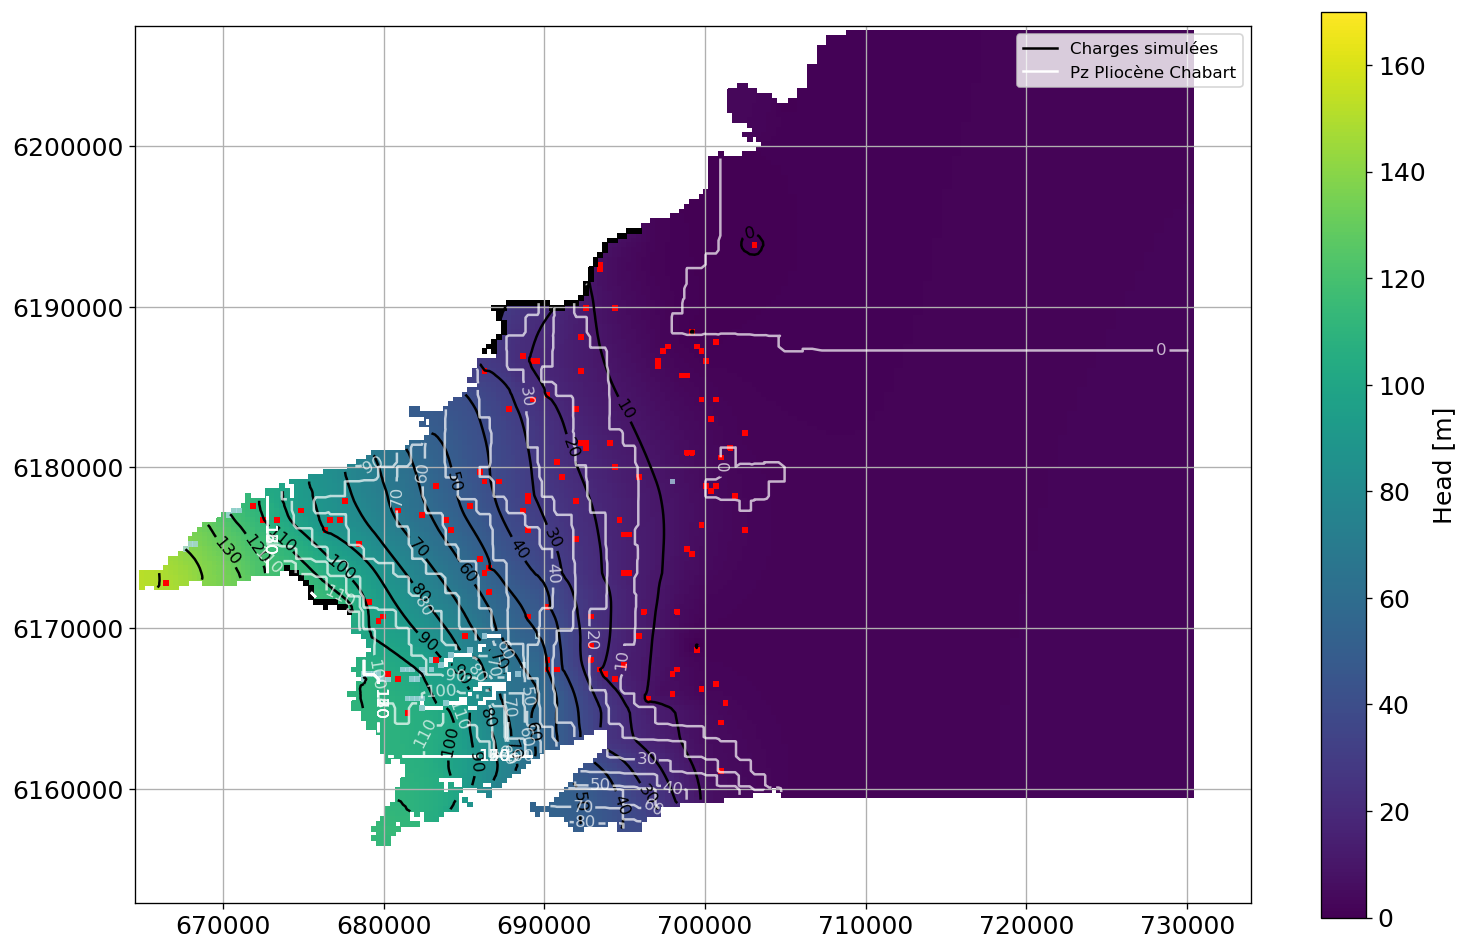

In [35]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(15,10),dpi=120)
layer = 3
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

##cont des mesures piézométriques
pz="../../data/cartes_pz/Pz_Pliocène_Avril2013.grd"
pz = "../../data/Chabart/charges_c3_proj.tif"
rast = Raster.load(pz)
Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)
Mes_pz[[head[layer]==1e30]]=None
cont_2=ml.contour_array(Mes_pz,levels=np.linspace(0,170,18),colors='white',alpha=0.7)
plt.clabel(cont_2,fmt="%1i")

#legend
proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="white")]
plt.legend(proxy,["Charges simulées","Pz Pliocène Chabart"])
# fp.plot.plot_shapefile("../../data/shp/entités/Q_ext_2.shp",facecolor="none",edgecolor="yellow",linewidth=2)

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel")
ml.plot_bc("Corb")
ml.plot_bc("thuir")

ax.tick_params(labelsize=15)

#colorbar
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

In [36]:
plt.rcParams.update({'font.size': 10})

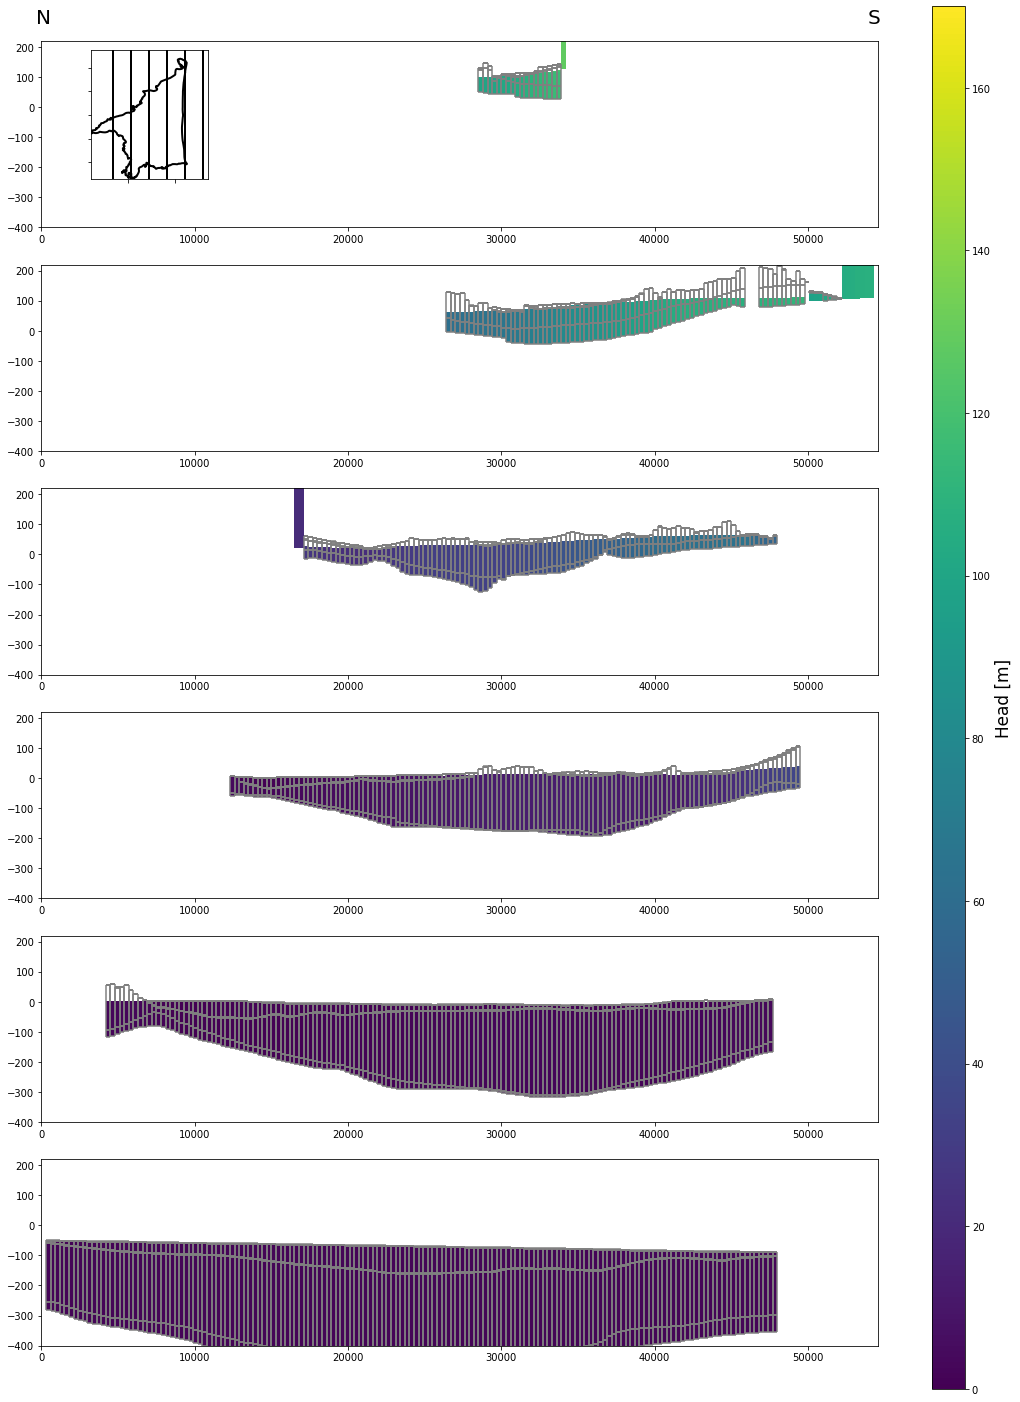

In [37]:
## pleins de cross sections

n=6 # nombre de cross à faire
fig,ax = plt.subplots(n,1,figsize=(15,4*n))

# Cross section initiale
row = 30 # ligne ou colonne ça n'a pas d'importance
rowi = row

# choose row(1) or col (0) by setting xstype
xstype = 0

# rows
if xstype : 
    for axi in ax:
        x=fp.plot.PlotCrossSection(gwf,line={"row" :row})
        arr=x.plot_array(head,masked_values=[1e30],head=head,ax=axi)
        arr.set_clim(0,170)
        x.plot_ibound(ax=axi)
        x.plot_grid(ax=axi)
        axi.set_ylim(-400,220)
        row+=150/n

    # plot lines position
    size = 1.5e-1
    axp = plt.axes([0.15,0.80,size,size/2]) # position of the mini plot with xsection locations, should be placed manually
    axp.set_xlim(x0,x1-2.1e4)
    axp.set_ylim(y0,y1)
    axp.set_aspect("equal")
    fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2,ax=axp)
    row = rowi # Cross section initiale
    for i in range(n):
        x = [x0,x1]
        y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
        axp.plot(x,y,"k",linewidth=1)
        row+=(nrow-1-rowi)/n
    axp.set_xticklabels([])
    axp.set_yticklabels([])
    fig.text(0.12,0.89,"W",fontsize=20)
    fig.text(0.89,0.89,"E",fontsize=20)
    
# columns
elif xstype == 0:
    col = row
    for axi in ax:
        x=fp.plot.PlotCrossSection(gwf,line={"column" :col})
        arr=x.plot_array(head,masked_values=[1e30],head=head,ax=axi)
        arr.set_clim(0,170)
        x.plot_ibound(ax=axi)
        x.plot_grid(ax=axi)
        axi.set_ylim(-400,220)
        col+=150/n

    # plot lines position
    size = 1.5e-1 # mini figure size
    axp = plt.axes([0.15,0.80,size,size/2]) # position of the mini plot with xsection locations, should be placed manually
    axp.set_xlim(x0,x1-2.1e4)
    axp.set_ylim(y0,y1)
    axp.set_aspect("equal")
    fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2,ax=axp)
    col = rowi # Cross section initiale
    coli = col
    for i in range(n):
        y = [y0,y1]
        x = [x0+(col+.5)*delr[0],x0+(col+.5)*delr[0]]
        axp.plot(x,y,"k",linewidth=2)
        col+=(ncol-1-coli)/n
    axp.set_xticklabels([])
    axp.set_yticklabels([])
    fig.text(0.12,0.89,"N",fontsize=20)
    fig.text(0.89,0.89,"S",fontsize=20)
    
#colorbar
cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(arr, cax = cbaxes)
cb.set_label("Head [m]",fontsize=17)

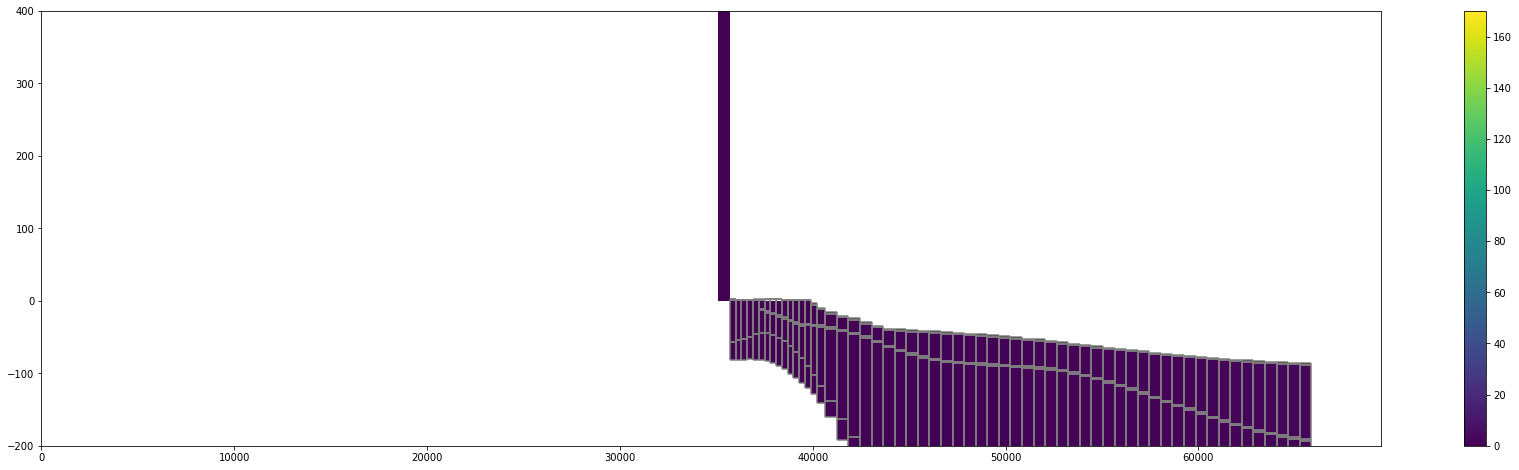

In [38]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)
x.plot_bc("sea")

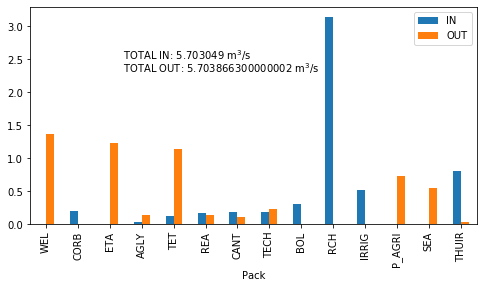

In [39]:
#total budget
import seaborn
fig,ax = plt.subplots(figsize=(8,4))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack",inplace=True)
Budget.loc["SEA","IN":"OUT"] -= Budget.loc["SEA","IN"]
Budget.plot(kind="bar",ax=ax)
ax.text(2.4,2.5,"TOTAL IN: {} m$^3$/s".format(Budget.sum()["IN"]));
ax.text(2.4,2.3,"TOTAL OUT: {} m$^3$/s".format(Budget.sum()["OUT"]));

Misfit : 3.6964429416670623 m 
MSE    : 57.32846299069849
φ      : 6994.072484865216


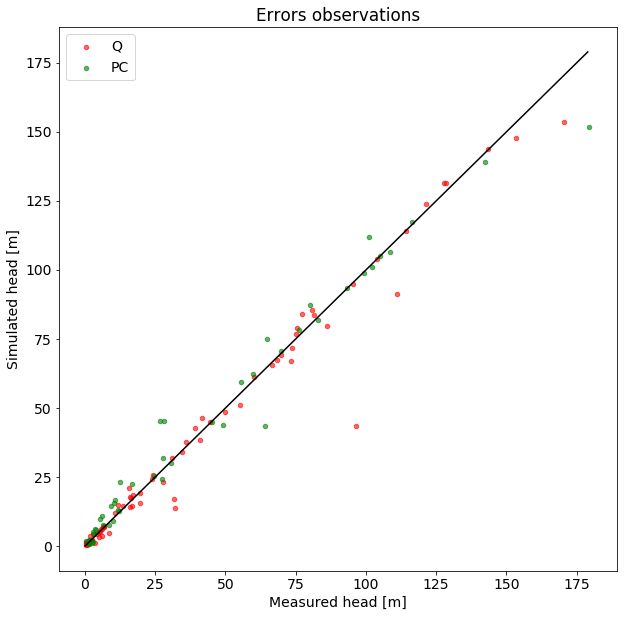

In [40]:
plt.rcParams.update({'font.size': 14})

head = get_heads(model_name,model_dir)
color = ["y","red","blue","green","black"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(10,10))

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

# stats
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
MSE = np.nanmean((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
phi = np.nansum((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
print("Misfit : {} m ".format(np.nanmean(Misfit)))
print("MSE    : {}".format(MSE))
print("\u03C6      : {}".format(phi))

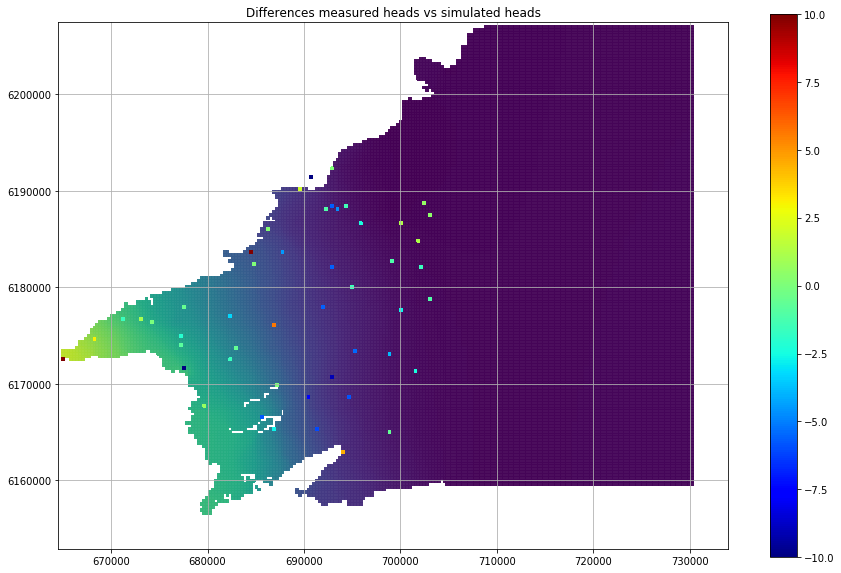

In [99]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(15,10))
layer = 3
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

back = ml.plot_array(head[layer],masked_values=[1e30],alpha=0.8)
back.set_clim(0,170)

head = head.reshape(nlay*nrow*ncol)
head[Control_pz==0]=None
comp = (Control_pz - head).reshape(nlay,nrow,ncol)
err = ml.plot_array(comp[layer],cmap="jet",vmin=-10,vmax=10)

plt.title("Differences measured heads vs simulated heads")

plt.colorbar(err)
plt.grid()

In [35]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    
    #permea
    ########------------------------------- 
    
    # layers
    K = np.ones([nlay,nrow,ncol])
    K[0] = 1e-6
    K[1] = kh[0]
    K[2] = 0.25e-8
    K[3] = kh[1]
    K[4] = kh[2]
    
    # zone sud
#     z1 = [(689e3,616e4),(695e3,616.3e4),(703e3,616.3e4),(703e3,615.2e4),(689e3,615.2e4)]
#     layer = [1,3,4]
#     kn = kh[2]
#     k_zones (K,z1,layer,kn,ix)
    
#     # permeabilité de la zone Villeneuve
#     x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
#     zv = [(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)]
#     layer = [1,3,4]
#     kn = kh[3]
#     k_zones(K,zv,layer,kn,ix)
    
#     # permea alluv ancien Tet
#     shp = "../../data/shp/entités/Tet_Q_anc.shp"
#     poly = gp.read_file(shp).geometry[0]
#     layer = [1]
#     kn = kh[4]
#     k_zones(K,poly,layer,kn,ix)
    
    ########-------------------------------------
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=K) # create the new npf package
    npf.write()
    
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
        head = head.reshape(nlay*nrow*ncol)
        
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0])))

In [36]:
# minimize(Misfit,[2e-3,9.8e-5,1e-5],method="Nelder-Mead")

### budget by zones

In [6]:
from Zone_Budget_mf6 import Zb

In [74]:
%%time
#create the zones
a = np.array([1,2,4,4,6]) # Quat, eponte + PC, PMS
a = a[np.newaxis,np.newaxis,:]
zones = np.ones([nlay,nrow,ncol])*a.T
#zones[idomain==0]=0
#zones[0][idomain[0]==1]=0 # Quat marin
zones[1][idomain[0]==1]=3 # Quat marin
zones[3][idomain[0]==1]=5 # Pc marin

dic_zones = {1:"interfQ",
            2 : "Q",
            3 : "Q marin",
            4 : "PC",
            5 : "PC marin",
            6 : "PMS"} # dic to attribute zone names !

#remove some pack cells from zone 1 with ra_pack
#ra_pack(chd,zones,iper=0,value=5)
#ra_pack(Riv2,zones,iper=0,value=6)
#ra_pack(Riv3,zones,iper=0,value=7)

# initiate object
zb = Zb(zones,model_name,model_dir,cbc=get_cbc(model_name,model_dir),dic_zones=dic_zones)
DF_Budg = zb.get_Budget() # get DF budget

Wall time: 3.91 s


In [80]:
(np.round(DF_Budg.Q,decimals=4)).replace(0,"/")

,FROM,TO
WEL,/,0.4512
CORB,/,/
ETA,/,1.2294
AGLY,0.0422,0.1353
TET,0.1315,1.1334
REA,0.1108,0.1276
CANT,0.0728,0.0862
TECH,0.1813,0.2317
BOL,0.3156,0.0028
RCH,2.1361,/


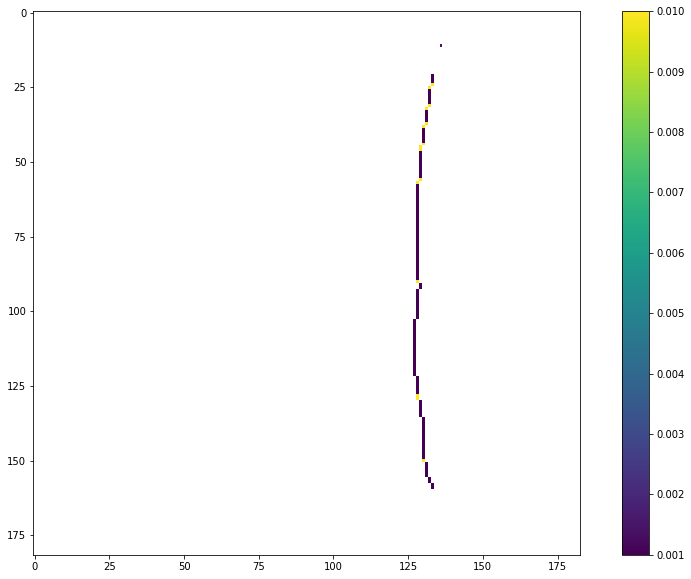

In [48]:
plt.figure(figsize=(15,10))
plt.imshow(zb.Z2Z_3D(2,3)[1],vmax=0.001,vmin=0.01)
plt.colorbar()

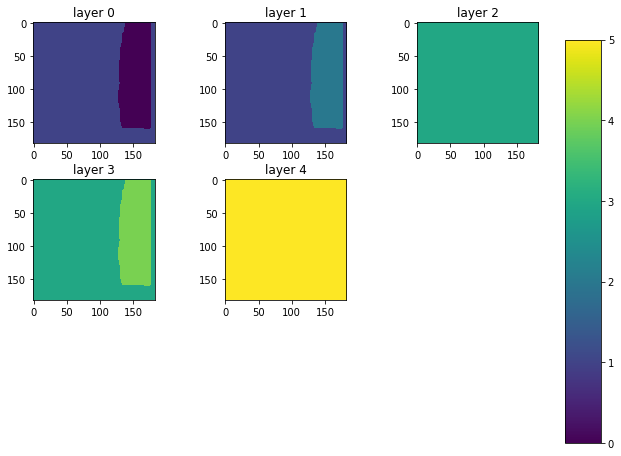

In [40]:
zb.zones_plot()

In [26]:
# remove excedent budget from sea
mask = DF_Budg.loc["SEA"]!=0
DF_Budg.loc["SEA"][mask] = DF_Budg.loc["SEA"][mask]-DF_Budg.loc["SEA"][mask].min()

KeyError: 5

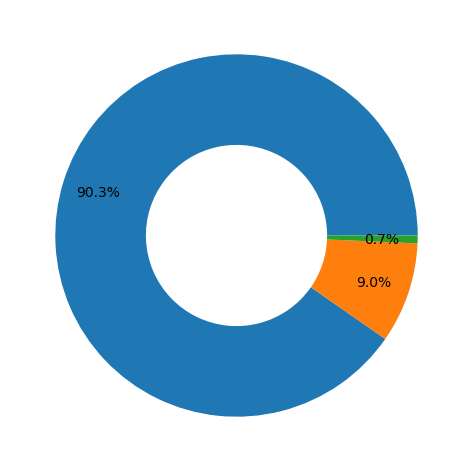

In [68]:
#plots donuts
nzones = get_nzones(zones)
if os.path.exists('pictures'):
    shutil.rmtree('pictures')
os.makedirs("pictures")

z_list = DF_Budg.index[-nzones:]
I_O_list = ["TO","FROM"]

dic_zones ={1:"Quaternaire",2:"InterQ_PC",3:"PC",4:"PMS"} # titles for zones

for z in z_list:
    for IN_OUT in I_O_list:
        fig,ax = plt.subplots(figsize=(9,6),dpi=100)
        labels = DF_Budg[DF_Budg[z][IN_OUT]!=0].index
        data = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].values
        data_pourc = DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0]/DF_Budg[z][IN_OUT][DF_Budg[z][IN_OUT]!=0].sum()
        
        wedges, texts,pct = ax.pie(data_pourc.values,pctdistance=0.8,
                                   wedgeprops=dict(width=0.5),autopct='%1.1f%%', startangle=0)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
        kw = dict(arrowprops=dict(arrowstyle="<-"),
                  bbox=bbox_props, zorder=0, va="center")
        xt = -5
        yt = -5
        ### arrows
        """
        for i, p in enumerate(wedges):
            xta = xt
            yta = yt
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            
            ang +=0.1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            xt = 1.3*np.sign(x)
            yt = 1.2*y
            if xt == xta:
                while((yta-yt)**2)< 0.0001:
                    if yt >= yta:
                        yt += 0.0001
                    else:
                        yt -= 0.0001
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            annote = np.round(data[i],2)
            ax.annotate(annote, xy=(x, y), xytext=(xt,yt),
                        horizontalalignment=horizontalalignment, **kw)
        ###
        """
        ax.set_title("{} : {}".format(dic_zones[int(z[-1])],IN_OUT))
        ax.set_position([0.1,0.1,0.5,0.7])
        ax.legend(wedges,labels,bbox_to_anchor=(1.5, 1))
        ax.text(-0.40,0,"TOTAL : {} m$^3/$s".format(np.round(data.sum(),3)))
        fig.savefig('pictures/{}_{}.png'.format(z,IN_OUT))
        plt.close()

In [63]:
def north(zoom=0.01,x0=664525+5e3,y0=6152875+5e3):
    
    """
    Plot a north image for maps
    """
    
    from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    arr_lena = mpimg.imread("../../images/north.png") # get image
    imagebox = OffsetImage(arr_lena,zoom=zoom) # create an image box
    ab = AnnotationBbox(imagebox, (x0,y0),frameon=False) # create the annotation box
    ax.add_artist(ab) # add the image

### Plots

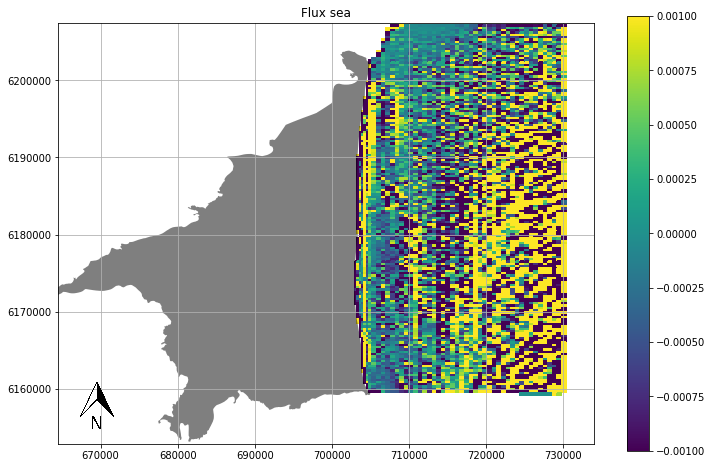

In [64]:
fig=plt.figure(figsize=(12,8))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=0)

g=zb.return_arr("SEA")
g=ml.plot_array(g)
g.set_clim(-0.001,0.001)

fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="k",edgecolor="none",linewidth=1,alpha=.5)

plt.grid()
plt.title("Flux sea")
fig.colorbar(g)

north(0.02)

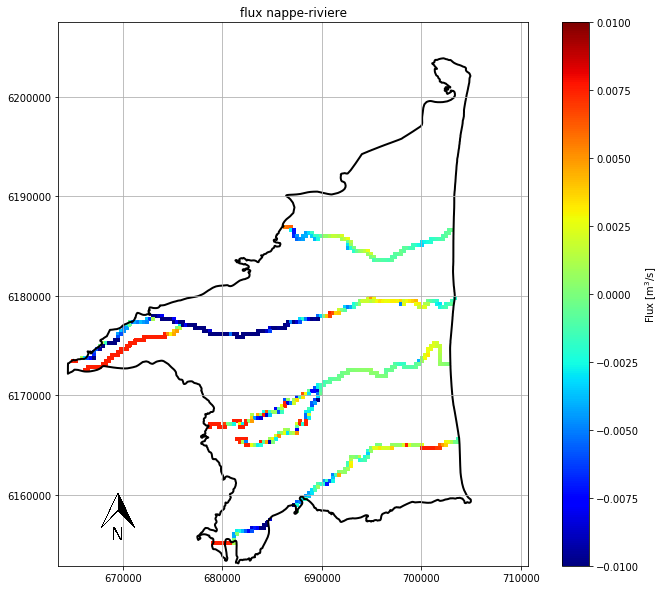

In [65]:
fig=plt.figure(figsize=(12,10))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=0)


riv = ["AGLY","BOL","TET","CANT","REA","TECH"]
for iriv in riv:
    g=zb.return_arr(iriv)
    g = ml.plot_array(g)
    g.set_cmap("jet")
    g.set_clim(-0.01,0.01)
    ax.set_xlim(x0-1e3,x1-2.4e4)
c = fig.colorbar(g)
c.set_label("Flux [m$^3$/s]")
fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2)

plt.grid()
plt.title("flux nappe-riviere")
north(0.02)

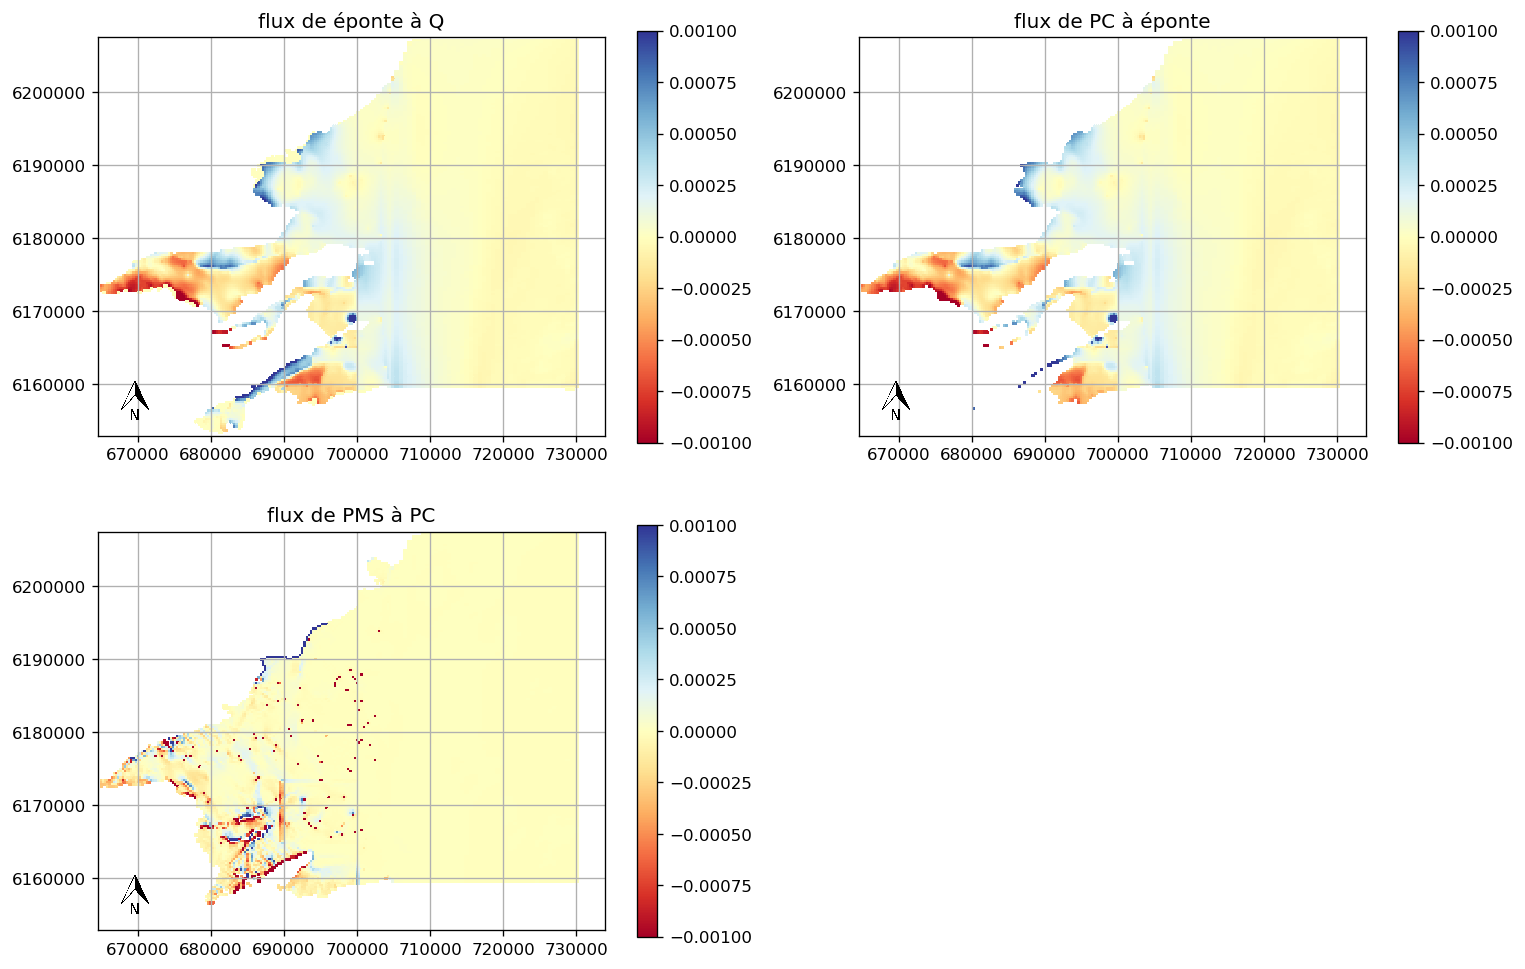

In [67]:
fig = plt.figure(figsize=(15,10),dpi=120)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for ilay in range(1,nlay-1):
    ax = fig.add_subplot(2,2,ilay)
    ax.set_aspect("equal")
    g = zb.Z2Z_3D(ilay,ilay+1)[ilay]
    g=ml.plot_array(g,ax=ax,cmap = "RdYlBu" )
    g.set_clim(-1e-3,1e-3)
    fig.colorbar(g)
    plt.grid()
    plt.title("flux de {} à {}".format(dic_zones[ilay+1],dic_zones[ilay]))
    north(0.01)

Plot idomain by layers

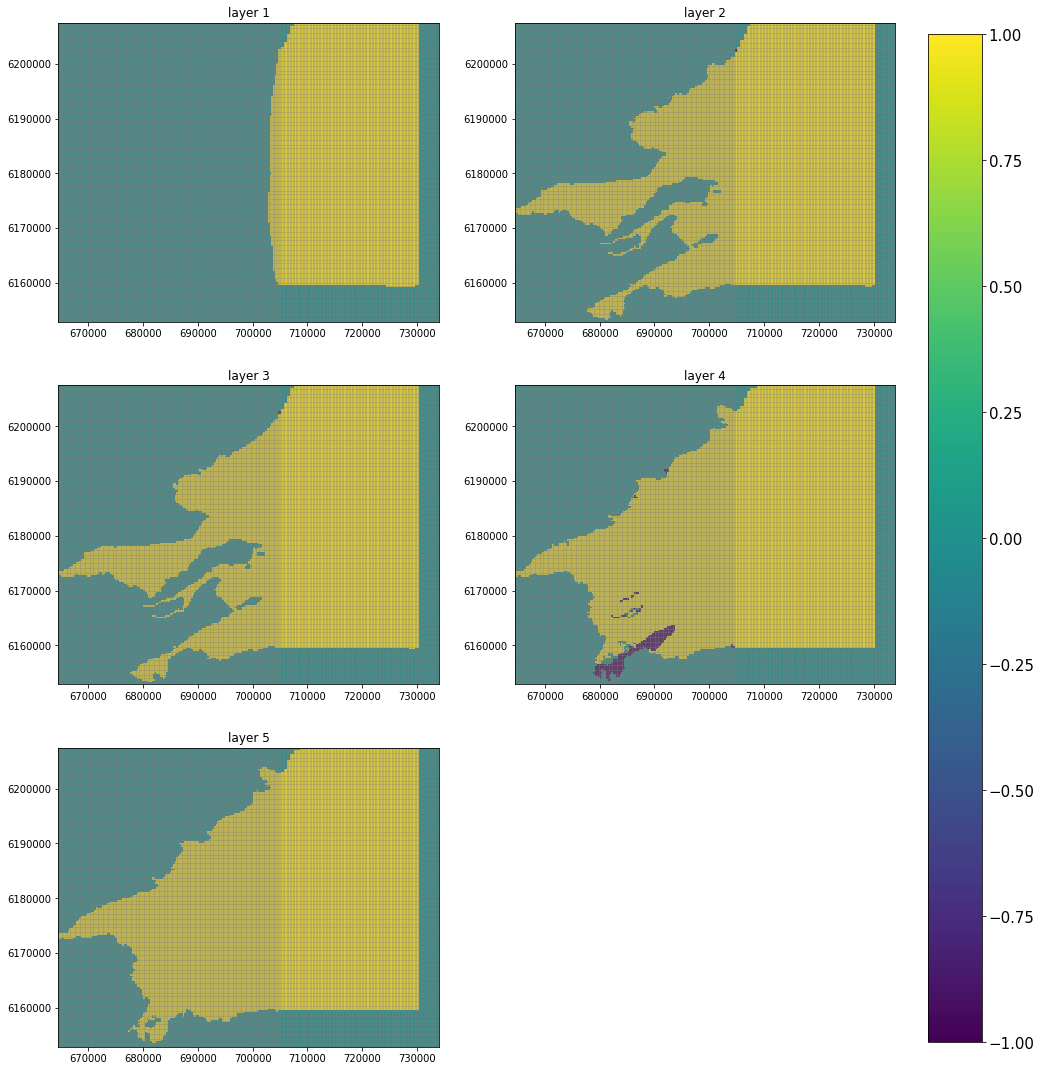

In [70]:
# initialize plot
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0, wspace=0.2)

for ilay in range(nlay):
    ax = fig.add_subplot(3,2,ilay+1)
    ml = fp.plot.PlotMapView(model=gwf,layer=ilay)
    ml.plot_grid(alpha=0.4)
    g=ml.plot_array(idomain[ilay],ax=ax)
    g.set_clim(-1,1)
    plt.title("layer {}".format(ilay+1))
    
cbar_ax = fig.add_axes([0.93, 0.15, 0.05, 0.7])
c = fig.colorbar(g,cax=cbar_ax)
c.ax.tick_params(labelsize=15)